Testing Blip with food images

In [1]:
# Load model directly
from transformers import pipeline, AutoProcessor, AutoModelForImageTextToText
from PIL import Image 
import requests
processor = AutoProcessor.from_pretrained("Salesforce/blip-image-captioning-large",use_fast=True)
model = AutoModelForImageTextToText.from_pretrained("Salesforce/blip-image-captioning-large")

/home/chahar/miniconda3/envs/food/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


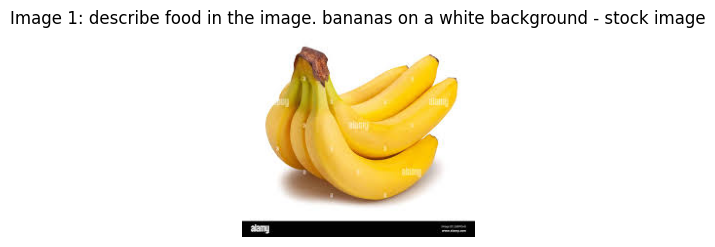

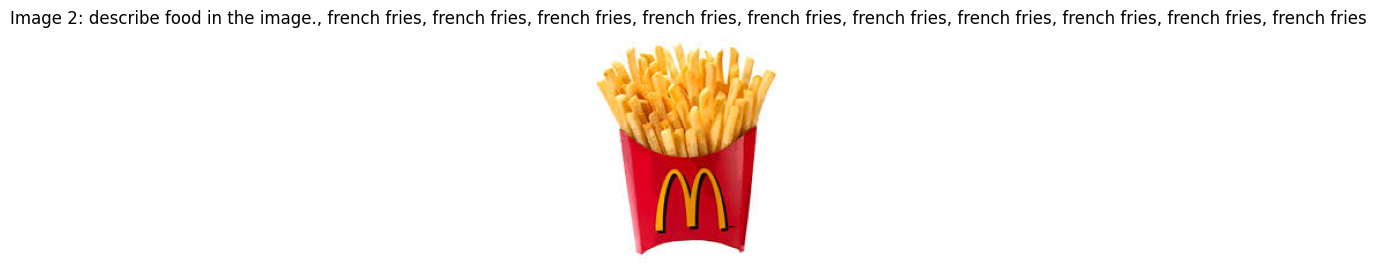

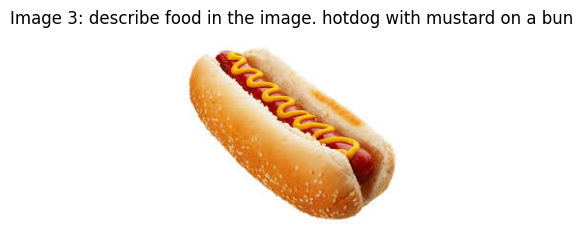

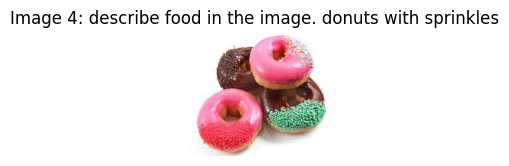

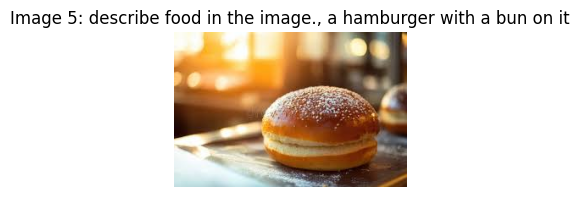

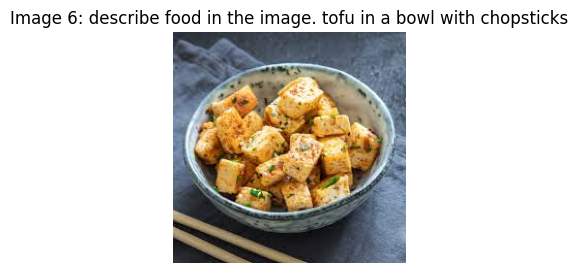

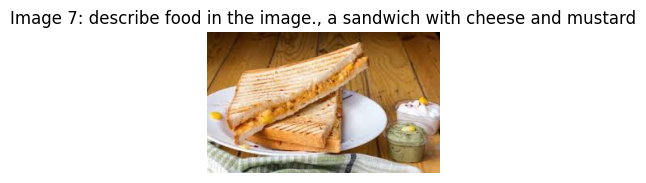

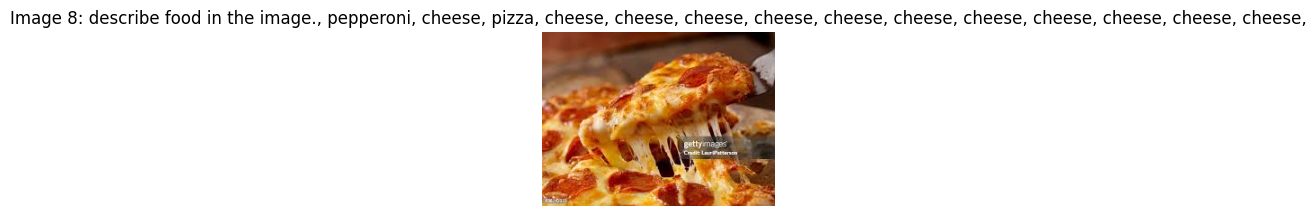

In [5]:
import matplotlib.pyplot as plt
image_path = ["Food_estimator_images/foods for blip/img1.jpg",
              "Food_estimator_images/foods for blip/img2.jpg",
              "Food_estimator_images/foods for blip/img3.jpg",
              "Food_estimator_images/foods for blip/img4.jpg",
              "Food_estimator_images/foods for blip/img5.jpg",
              "Food_estimator_images/foods for blip/img6.jpg",
              "Food_estimator_images/foods for blip/img7.jpg",
              "Food_estimator_images/foods for blip/img8.jpg"]

for i, path in enumerate(image_path, start=1):
    try:
        image = Image.open(path).convert("RGB")
        prompt = "Describe food in the image."
        inputs = processor(images=image, text=prompt, return_tensors="pt").to(model.device)

        generated_ids = model.generate(**inputs, max_new_tokens=30)
        caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
        plt.figure(figsize=(3, 3))
        plt.imshow(image)
        plt.axis('off')
        plt.title(f"Image {i}: {caption}", fontsize=12)
        plt.show()
    except Exception as e:
        print(f"Error with {path}: {e}")

